In [1]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm
from scipy.interpolate import interp1d
import pandas as pd
from CoolProp.CoolProp import PropsSI

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.fractional_flow as ff
import pymadreq.IO as IO

reload(ff)
reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'c:\\Users\\aaeft\\Documents\\GitHub\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [2]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

## Read the Excel file of the experimental data

In [3]:
# TODO: add excel reader for updating the model input for optimization
# df = pd.read_excel("E-31-1-flooding-formatted.xlsx")
xls = pd.ExcelFile("E-31-1-flooding-formatted.xlsx")
sheet_names = xls.sheet_names
print(sheet_names)

['core', 'condition', 'brine', 'oil', 'drainage_dp', 'drainage_So', 'flooding_dp', 'flooding_R', 'flooding_effluent']


In [4]:
df = pd.read_excel("E-31-1-flooding-formatted.xlsx", sheet_name=None)

In [5]:
core_dics = df['core'].set_index('parameter')['value'].to_dict()
oil_dict = df['oil'].set_index('property')['value'].to_dict()
cond_dict = df['condition'].set_index('parameter')['value'].to_dict()

In [6]:
df['condition']

,parameter,value,unit
0,temperature,70.0,degC
1,back_pressure,200.0,bar
2,injection_rate,0.1,cm^3/min


In [7]:
BC.injection_rate_ml_min = cond_dict['injection_rate'] # ml/min
BC.production_pressure = cond_dict['back_pressure']*1e5 # Pa
T = cond_dict['temperature'] + 273.15 # K

core_plug.core_length = core_dics['L']/100 # m
core_plug.core_diameter = core_dics['D']/100 # m
core_plug.porosity = core_dics['porosity']
core_plug.permeability = core_dics['perm_water']*1e-15 # m2
core_plug.pore_volume = core_dics['pore_volume']/1e6 # m3
core_plug.cross_sectional_area = core_plug.core_diameter**2*np.pi/4 # m2

fluids.oil_density = oil_dict['density'] # kg/m3
fluids.oil_viscosity = oil_dict['viscosity'] # Pa.s
fluids.water_density = PropsSI('D', 'T', T, 'P', BC.production_pressure, 'water') # kg/m3
fluids.water_viscosity = PropsSI('V', 'T', T, 'P', BC.production_pressure, 'water') # Pa.s

IC.sw = 1 - core_dics['Soi']
IC.p = BC.production_pressure
IC.T = T

In [8]:
# estimate initial pressure drop and other parameters
# u = k/mu_oil*dp0/L -> dp0 = u*L*mu_oil/k
u_inj = (BC.injection_rate_ml_min*1e-6/60)/core_plug.cross_sectional_area # m/s
dp0 = u_inj*core_plug.core_length*fluids.oil_viscosity/core_plug.permeability
dp0 = dp0/1e5 # bar

In [9]:
# df_sw = df['flooding_R'][df['flooding_R']['brine']=='SW']
df_sw = df['flooding_R']
df_sw = df_sw[df_sw['injecting brine']=='SW']
PV_R = df_sw['PV'].to_numpy()
R = df_sw['RF'].to_numpy()
# cm3/s x t = cm3 = pv x pore_volume -> t = pv x pore_volume[cm3] / cm3/s
t_R = PV_R * core_plug.pore_volume*1e6 / (BC.injection_rate_ml_min/60)
df_dp = df['flooding_dp']
df_dp = df_dp[df_dp['injecting brine']=='SW']
PV_dp = df_dp['PV'].to_numpy()
dp = df_dp['DeltaP'].to_numpy()
dp_filtered = interp1d(PV_dp, dp, kind='linear', fill_value='extrapolate')(PV_R)

numerical_params.simulation_time = t_R[-1]*1.1

In [10]:
# estimate the water relative permeability end point
# u = k.krw/muw*dp/L -> krw = u*muw*L/(k*dp)
krw_end_est = u_inj*fluids.water_viscosity*core_plug.core_length/(core_plug.permeability*dp_filtered[-1]*1e5)
krw_end_est

0.17630823032912551

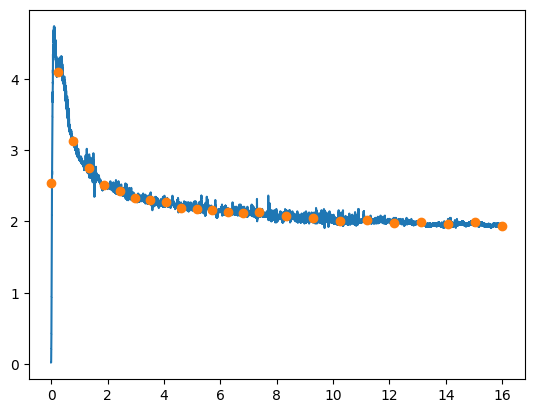

In [11]:
plt.plot(PV_dp, dp)
dp_filtered[0] = dp0
plt.plot(PV_R, dp_filtered, 'o')

In [12]:
cf_1d = cf.CoreFlooding1D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=30
)

cf2d = cf.CoreFlooding2D(
    rel_perm_ww, pc_ww, core_plug, fluids, IC, BC, numerical_params, Nx=20, Nr = 5
)

# xt_shock, sw_shock, xt_prf, sw_prf, t_ana, p_inj_ana, R_oil_ana = ff.frac_flow_wf(
#     fluids, rel_perm_ww, core_plug, IC, ut=cf_1d.u_inj, sw_inj=1.0, pv_inj=3.0)

c:\Users\aaeft\venvs\myfvm\Lib\site-packages\pyfvtool\cell.py:97: RuntimeWarning: invalid value encountered in divide
  return CellVariable(self.domain, self.value/other.value)


In [13]:
t_data, R_data, dp_data = t_R, R, dp_filtered*1e5 #cf_1d.simulate_no_pc()


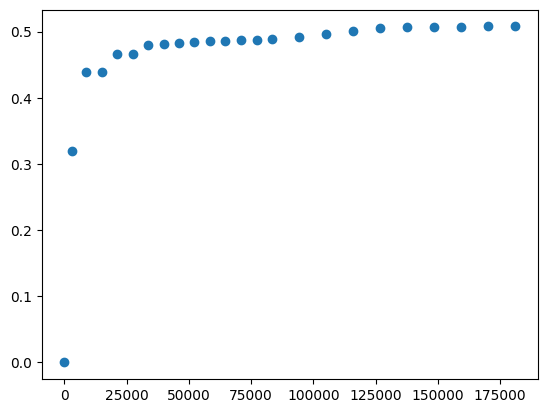

In [14]:
plt.plot(t_data, R_data, 'o')
# cf_1d.numerical_params.simulation_time = 130000.0

## Fittin model to core flooding data

In [15]:
# using lmfit to fit a two-phase model to a dataset
from lmfit import minimize, Parameters, Model
def residual(params, t, R):
    cf_1d.rel_perm.kro0 = params['kro0']
    cf_1d.rel_perm.krw0 = params['krw0']
    cf_1d.rel_perm.nw = params['nw']
    cf_1d.rel_perm.no = params['no']
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num)(t)
    return (R_calc - R)

def my_model(t, krw0, kro0, nw, no, swc, sor):
    cf_1d.rel_perm.kro0 = kro0
    cf_1d.rel_perm.krw0 = krw0
    cf_1d.rel_perm.nw = nw
    cf_1d.rel_perm.no = no
    cf_1d.rel_perm.swc = swc
    cf_1d.rel_perm.sor = sor
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num, fill_value='extrapolate')(t)
    dp_calc = interp1d(t_num, dp_num, fill_value='extrapolate')(t)
    return R_calc, dp_calc

def my_model2(t, krw0, kro0, nw, no, swc, sor):
    cf_1d.rel_perm.kro0 = kro0
    cf_1d.rel_perm.krw0 = krw0
    cf_1d.rel_perm.nw = nw
    cf_1d.rel_perm.no = no
    cf_1d.rel_perm.swc = swc
    cf_1d.rel_perm.sor = sor
    t_num, R_num, dp_num = cf_1d.simulate_no_pc()
    R_calc = interp1d(t_num, R_num, fill_value='extrapolate')(t)
    # dp_calc = interp1d(t_num, dp_num, fill_value='extrapolate')(t)
    return R_calc

model = Model(my_model)
model2 = Model(my_model2)

params = Parameters()
params.add('kro0', value=0.5, min=0.1, max=1.0)
params.add('krw0', value=krw_end_est, min=0.05, max=0.6, vary=False)
params.add('no', value=2.0, min=1.0, max=4.0)
params.add('nw', value=2.0, min=1.0, max=4.2)
params.add('swc', value=IC.sw, min=0.01, max=0.25, vary=False)
params.add('sor', value=0.2, min=0.01, max=0.5, vary=False)

W_R = np.ones_like(t_data)
W_R[-2:] = 5.0
W_dp = np.ones_like(t_data)/dp_data.max()
arg_dp_max = np.argmax(dp_data)
W_dp[arg_dp_max:arg_dp_max+1] *= 5.0
result = model.fit((R_data, dp_data), params, t=t_data, verbose=True, 
                   weights=(W_R, W_dp), method='powell')
# result2 = model2.fit(R_data, params, t=t_data, verbose=True, 
#                      weights=W_R, method='nelder')
# out = minimize(residual, params, args=(t_data, R_data))

In [22]:
print(result.fit_report())
print("Optimized Parameters:")
print(result.params)

[[Model]]
    Model(my_model)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 438
    # data points      = 48
    # variables        = 3
    chi-square         = 1.95270693
    reduced chi-square = 0.04339349
    Akaike info crit   = -147.695253
    Bayesian info crit = -142.081650
    R-squared          = 1.00000000
[[Variables]]
    kro0:  0.61615101 +/- 2.2787e-04 (0.04%) (init = 0.5)
    krw0:  0.1763082 (fixed)
    no:    2.99990637 +/- 4.5873e-06 (0.00%) (init = 2)
    nw:    1.16620925 +/- 1.4538e-04 (0.01%) (init = 2)
    swc:   0.1971 (fixed)
    sor:   0.2 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kro0, nw) = +0.4547
    C(no, nw)   = -0.3349
    C(kro0, no) = +0.3064
Optimized Parameters:
Parameters([('kro0', <Parameter 'kro0', value=0.6161510105788608 +/- 0.000228, bounds=[0.1:1.0]>), ('krw0', <Parameter 'krw0', value=0.17630823032912551 (fixed), bounds=[0.05:0.6]>), ('no', <Parameter 'no', value=2.9999063668732875 +/- 

In [17]:
# save the result to a json file
# with open('kr_flooding_fit.json', 'w') as f:
#     json.dump(result_dict, f)

In [23]:
R_fit, dp_fit = result.eval()


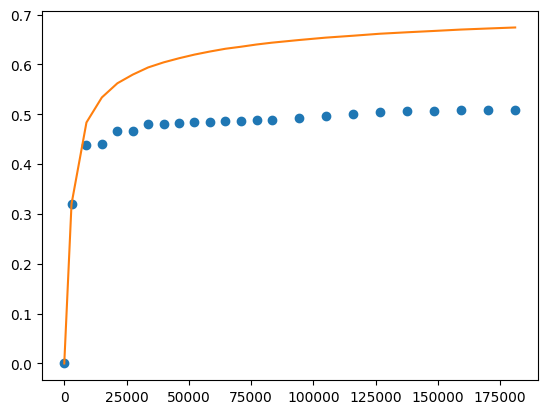

In [24]:
plt.plot(t_data, R_data, 'o')
plt.plot(t_data, R_fit, '-')

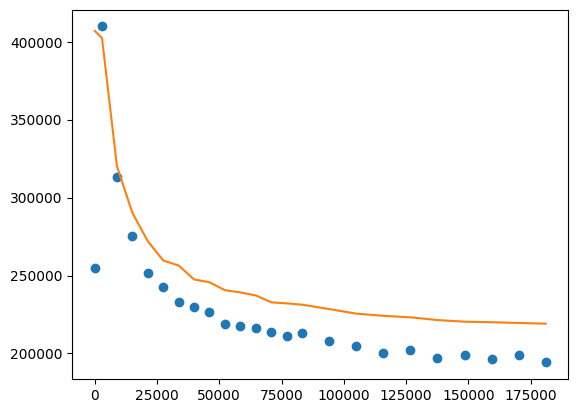

In [25]:
plt.plot(t_data, dp_data, 'o')
plt.plot(t_data, dp_fit, '-')

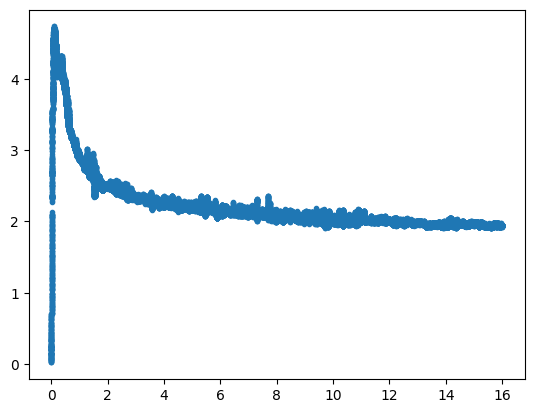

In [21]:
plt.plot(PV_dp, dp, '.')
